In [2]:
import torch
from models.visual import VisualEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Create encoder (use pretrained=False in tests to avoid download)
enc = VisualEncoder(backbone_name="xception", pretrained=False, lstm_hidden=512, lstm_layers=1).to(device)
print(enc)

# Dummy batch: B=2, T=8, C=3, H=224, W=224
B, T, C, H, W = 2, 8, 3, 224, 224
x = torch.randn(B, T, C, H, W).to(device)

with torch.no_grad():
    out = enc(x)
print("Output shape:", out.shape)  # expect (B, out_dim)
print("Out dim:", enc.get_out_dim())

Device: cuda


C:\Users\muthu\miniconda3\envs\multi_env\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


VisualEncoderr(backbone=Xception, frame_feat_dim=2048, out_dim=1024)
Output shape: torch.Size([2, 1024])
Out dim: 1024


In [1]:
from src.models.audio import AudioEncoder
import torch

model = AudioEncoder().cuda()

wav = torch.randn(2, 16000 * 3).cuda()  # 3 sec fake audio
out = model(wav)

print(out.shape)
print(model.out_dim)

C:\Users\muthu\miniconda3\envs\my_cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\muthu\miniconda3\envs\my_cv\Lib\site-packages\transformers\configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([2, 768])
768


In [2]:
print(model.out_dim)

768


In [3]:
import mediapipe
print(mediapipe.__version__)

0.10.21


In [4]:
0

0

In [27]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import mediapipe as mp

# global Mediapipe detector
FACE_DET = mp.solutions.face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)


In [28]:
def extract_face(frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = FACE_DET.process(rgb)

    if not results.detections:
        return None
    
    det = results.detections[0]
    bbox = det.location_data.relative_bounding_box
    h, w, _ = frame.shape

    x1 = int(bbox.xmin * w)
    y1 = int(bbox.ymin * h)
    x2 = int((bbox.xmin + bbox.width) * w)
    y2 = int((bbox.ymin + bbox.height) * h)

    return frame[y1:y2, x1:x2]

In [29]:
img_path = "test.jpg"   # <--- change this to any real image with a face
frame = cv2.imread(img_path)

if frame is None:
    print("Image not found!")
else:
    face = extract_face(frame)
    if face is not None:
        cv2.imshow("Original", frame)
        cv2.imshow("Detected Face", face)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [22]:
class CelebDFVisualDataset(Dataset):
    def __init__(self, root_dir, frames_per_video=8):
        self.root_dir = Path(root_dir)
        self.frames_per_video = frames_per_video
        
        self.video_paths = []
        self.labels = []

        # correct CelebDF mapping
        folders = {
            "Celeb-real": 1,
            "YouTube-real": 1,
            "Celeb-synthesis": 0
        }

        for folder, lbl in folders.items():
            folder_path = self.root_dir / folder
            videos = list(folder_path.glob("*.mp4"))
            for v in videos:
                self.video_paths.append(str(v))
                self.labels.append(lbl)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.video_paths)

    def _read_video_frames(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        idxs = torch.linspace(0, total_frames - 1, self.frames_per_video).long()
        frames = []
    
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(i.item()))
            ret, frame = cap.read()
            if not ret:
                continue
    
            face = extract_face(frame)
            if face is None:
                continue
    
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            img = self.transform(face)
    
            # Ensure 3 channels
            if img.dim() == 2:
                img = img.unsqueeze(0).repeat(3,1,1)
            elif img.shape[0] != 3:
                img = img[:3]  # just in case
    
            frames.append(img)
    
        cap.release()
    
        # Pad missing frames with black frames (3,224,224)
        while len(frames) < self.frames_per_video:
            frames.append(torch.zeros((3, 224, 224), dtype=torch.float32))
    
        return torch.stack(frames)


    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = self._read_video_frames(video_path)
        label = self.labels[idx]
        return frames, torch.tensor(label)

In [23]:
dataset = CelebDFVisualDataset("../../data/celeb_df", frames_per_video=8)

In [24]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [25]:
frames, label = next(iter(loader))

print("Frames shape:", frames.shape)  # expect (1, 8, 3, 224, 224)
print("Label:", label)

Frames shape: torch.Size([1, 8, 3, 224, 224])
Label: tensor([0])


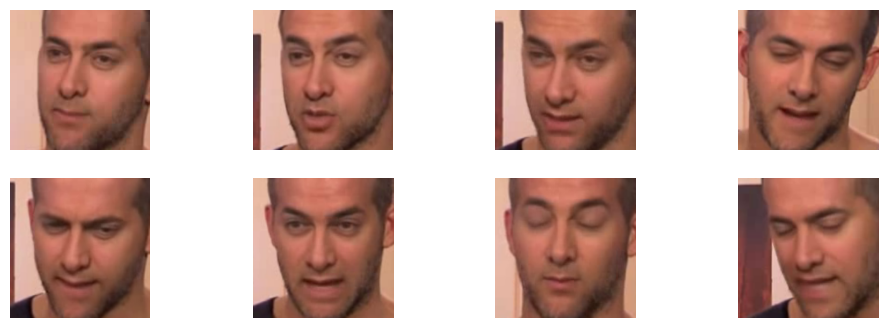

In [26]:
import matplotlib.pyplot as plt
frames = frames[0]  # remove batch dim
plt.figure(figsize=(12, 4))

for i in range(8):
    plt.subplot(2, 4, i+1)
    img = frames[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")

plt.show()

In [30]:
from models.image import ImageEncoder
import torch

enc = ImageEncoder()
x = torch.randn(4, 3, 224, 224)
out = enc(x)

print(out.shape)
print("Embedding dim:", enc.get_out_dim())


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

C:\Users\muthu\miniconda3\envs\multi_env\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\muthu\.cache\huggingface\hub\models--timm--efficientnet_b3.ra2_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


torch.Size([4, 512])
Embedding dim: 512
